In [ ]:
# Use seaborn for pairplot.
!pip install -q seaborn

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import ssl
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

print(tf.__version__)

2.17.0


In [ ]:
ssl._create_default_https_context = ssl._create_unverified_context

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [ ]:
# 清理无效的数据
dataset = raw_dataset.copy()
dataset.tail()

dataset.isna().sum()
dataset = dataset.dropna()

# Origin列进行独热编码
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset = dataset.astype({'USA': float, 'Europe': float, 'Japan': float})
print(dataset.tail())

      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Europe  Japan  USA  
393          82     0.0    0.0  1.0  
394          82     1.0    0.0  0.0  
395          82     0.0    0.0  1.0  
396          82     0.0    0.0  1.0  
397          82     0.0    0.0  1.0  


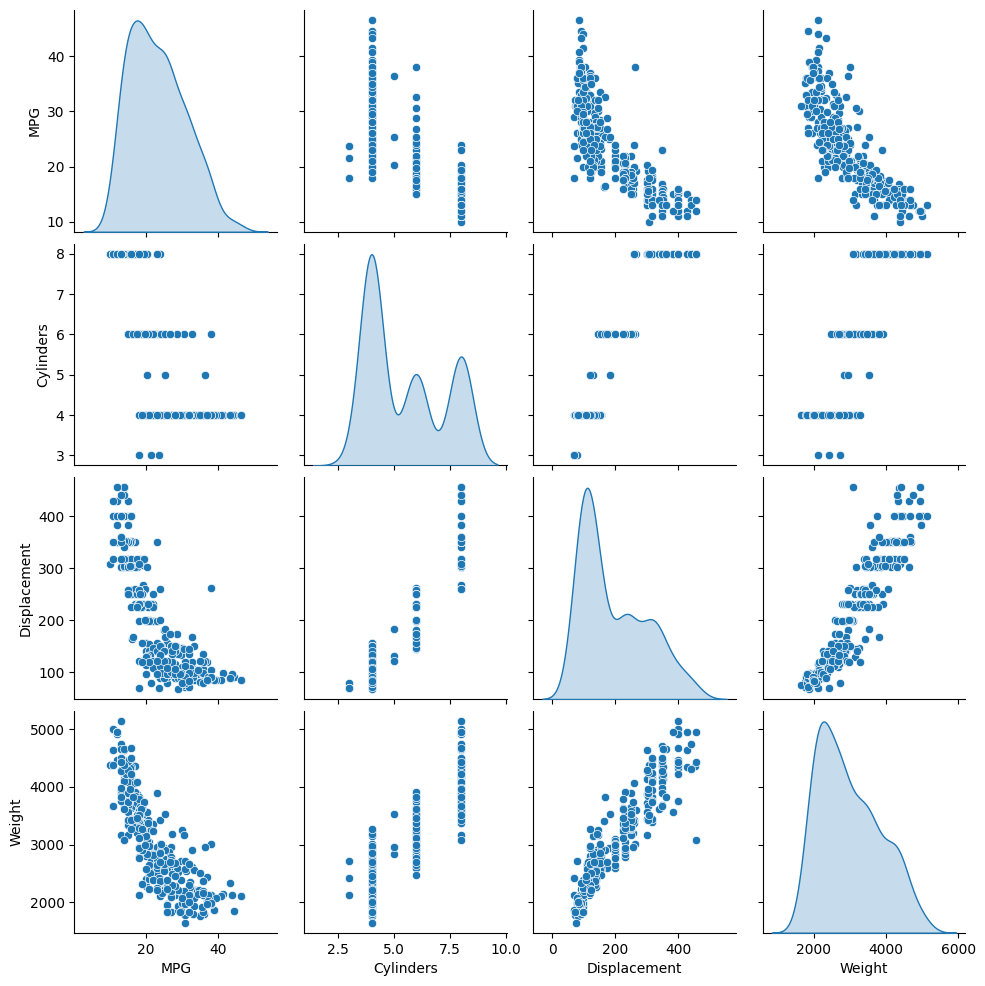

In [ ]:
# 数据拆分为训练集和测试集
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# 生成散点图
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')
plt.show()

In [ ]:
# 训练集总体统计数据
train_stats = train_dataset.describe().transpose()
print(train_stats)

              count         mean         std     min      25%     50%  \
MPG           314.0    23.310510    7.728652    10.0    17.00    22.0   
Cylinders     314.0     5.477707    1.699788     3.0     4.00     4.0   
Displacement  314.0   195.318471  104.331589    68.0   105.50   151.0   
Horsepower    314.0   104.869427   38.096214    46.0    76.25    94.5   
Weight        314.0  2990.251592  843.898596  1649.0  2256.50  2822.5   
Acceleration  314.0    15.559236    2.789230     8.0    13.80    15.5   
Model Year    314.0    75.898089    3.675642    70.0    73.00    76.0   
Europe        314.0     0.178344    0.383413     0.0     0.00     0.0   
Japan         314.0     0.197452    0.398712     0.0     0.00     0.0   
USA           314.0     0.624204    0.485101     0.0     0.00     1.0   

                  75%     max  
MPG             28.95    46.6  
Cylinders        8.00     8.0  
Displacement   265.75   455.0  
Horsepower     128.00   225.0  
Weight        3608.00  5140.0  
Acce

In [98]:
# 拆分训练集和测试集的预测值
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

train_dataset.describe().transpose()[['mean', 'std']]

# 初始化特征规范化层
normalizer = layers.Normalization(axis=-1)

normalizer.adapt(np.array(train_features))

print(normalizer.mean.numpy())

first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]
First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


In [ ]:
# Linear regression with one variable

# 初始化(horsepower)特征规范化层
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1, ], axis=None)
horsepower_normalizer.adapt(horsepower)

# 创建顺序模型
horsepower_model = keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

# 打印模型概述
horsepower_model.summary()

# 编译模型
horsepower_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

# 训练模型
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split=0.2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_4 (Normalization)      │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

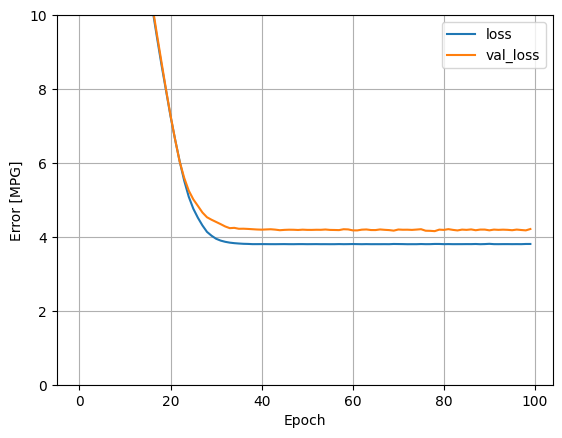

In [100]:
# 绘制训练过程中损失(loss)和验证损失(val_loss)的图表
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)


plot_loss(history)

In [ ]:
# 收集当前模型的评估结果
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

print(test_results)

{'horsepower_model': 3.64516282081604}


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


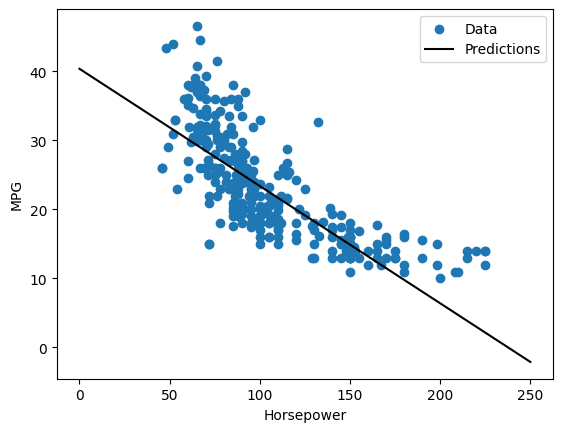

In [105]:
# 绘制散点图和预测线
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)


def plot_horsepower(x, y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()


plot_horsepower(x, y)

In [ ]:
# Linear regression with multiple inputs

# 创建顺序模型
linear_model = keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

# 打印模型概述
linear_model.summary()

# 编译模型
linear_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

# 训练模型
linear_history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split=0.2)

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization)      │ (314, 9)                    │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

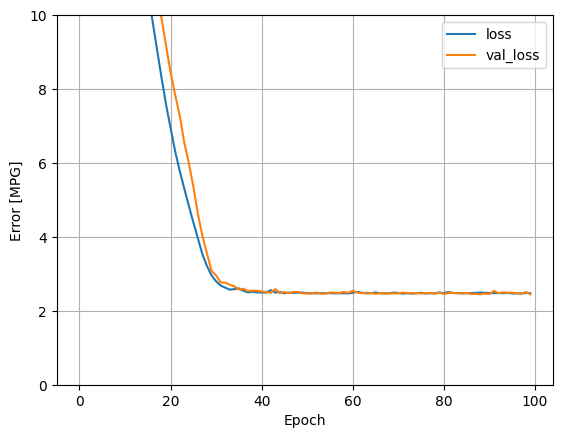

In [ ]:
# 绘制训练过程中损失(loss)和验证损失(val_loss)的图表
plot_loss(linear_history)

In [ ]:
# 收集当前模型的评估结果
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)
print(test_results)

{'horsepower_model': 3.64516282081604, 'linear_model': 2.449787139892578}


In [ ]:
# Regression using a DNN and a single input

# 定义模型
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                  optimizer=keras.optimizers.Adam(0.001))
    return model

In [ ]:
# 创建模型
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

# 打印模型概述
dnn_horsepower_model.summary()

# 训练模型
dnn_horsepower_history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_4 (Normalization)      │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

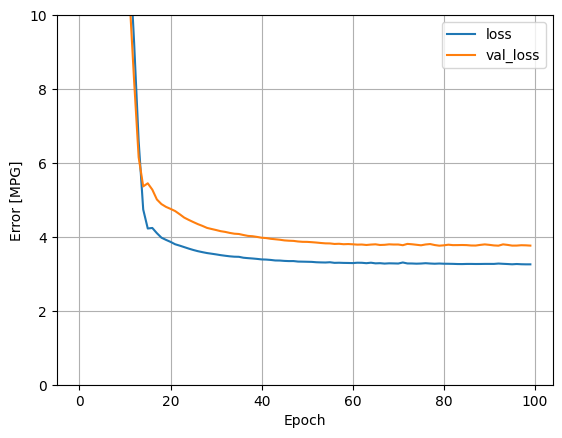

In [ ]:
# 绘制训练过程中损失(loss)和验证损失(val_loss)的图表
plot_loss(dnn_horsepower_history)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


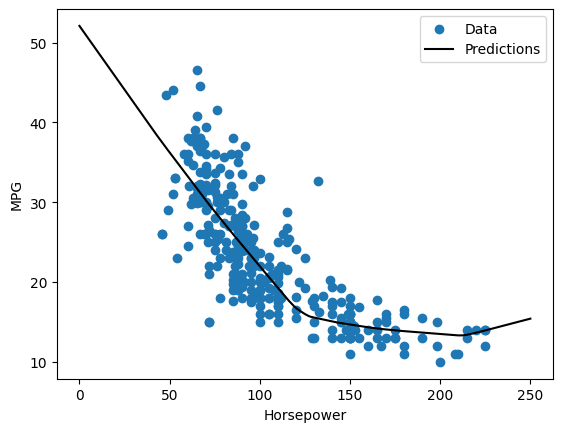

In [ ]:
# 绘制散点图和预测线
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

plot_horsepower(x, y)

In [ ]:
# 收集当前模型的评估结果
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

print(test_results)

{'horsepower_model': 3.64516282081604, 'linear_model': 2.449787139892578, 'dnn_horsepower_model': 2.9193341732025146}


In [ ]:
# Regression using a DNN and multiple inputs

# 创建模型
dnn_model = build_and_compile_model(normalizer)

# 打印模型概述
dnn_model.summary()

# 训练模型
dnn_history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization)      │ (None, 9)                   │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

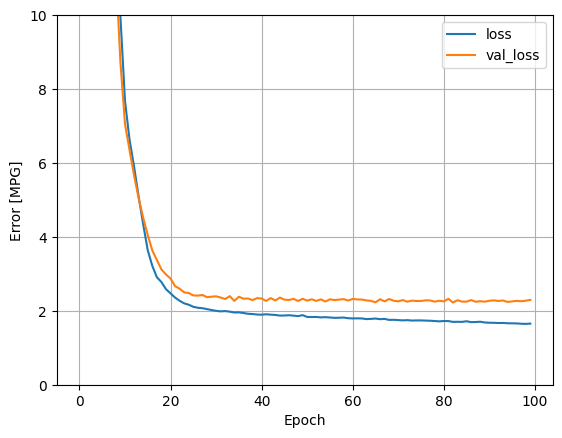

In [ ]:
# 绘制训练过程中损失(loss)和验证损失(val_loss)的图表
plot_loss(dnn_history)

In [ ]:
# 收集当前模型的评估结果
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

print(test_results)

{'horsepower_model': 3.64516282081604, 'linear_model': 2.449787139892578, 'dnn_horsepower_model': 2.9193341732025146, 'dnn_model': 1.7142527103424072}


In [ ]:
# Performance

# 各模型MAE对比
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.645163
linear_model,2.449787
dnn_horsepower_model,2.919334
dnn_model,1.714253


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


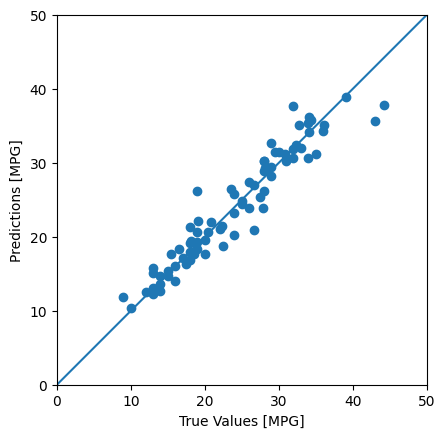

In [ ]:
# 绘制散点图和预测线
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

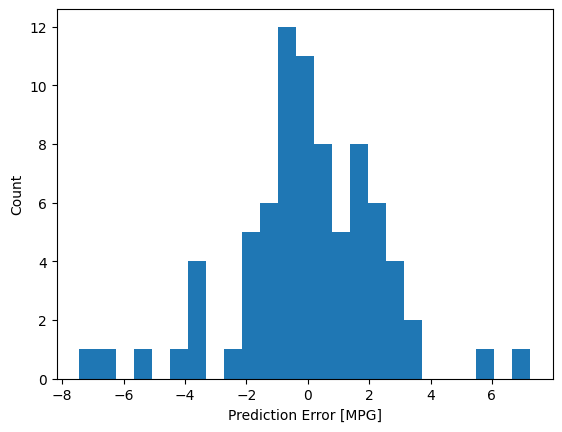

In [ ]:
# 绘制错误分布图
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [ ]:
# 保存模型
dnn_model.save('dnn_model.keras')